# Overview

This notebook shows how to define a kernel that is robust to uncalibrated data in the input dimension.

In [187]:
import matplotlib.pyplot as plt
import torch
from botorch.models import MultiTaskGP
from botorch.fit import fit_gpytorch_mll
from gpytorch.mlls import ExactMarginalLogLikelihood

## Robustness to wrong calibration in output

The multifidelity kernel is naturally robust to mismatch between the two fidelities in the output dimension.

In [188]:
from torch import Tensor
from gpytorch.distributions.multivariate_normal import MultivariateNormal
from gpytorch.module import Module
from botorch.models.transforms.input import InputTransform
from botorch.models.transforms.outcome import OutcomeTransform
from botorch.utils.types import _DefaultType, DEFAULT
from gpytorch.likelihoods.likelihood import Likelihood
from gpytorch.priors.prior import Prior

class ShiftedMultiTaskGP(MultiTaskGP):
    """Multi-task GP with task-specific input shifts.

    This model extends MultiTaskGP by adding task-specific shift parameters
    Δx_{s,s'} to the kernel, resulting in a kernel of the form:
    k[(s,x), (s',x')] = κ_{s,s'} * k(x - x' - Δx_{s,s'})

    where κ_{s,s'} is the task covariance and k is the base kernel.
    """

    def __init__(
        self,
        train_X: Tensor,
        train_Y: Tensor,
        task_feature: int,
        train_Yvar: Tensor | None = None,
        mean_module: Module | None = None,
        covar_module: Module | None = None,
        likelihood: Likelihood | None = None,
        task_covar_prior: Prior | None = None,
        output_tasks: list[int] | None = None,
        rank: int | None = None,
        all_tasks: list[int] | None = None,
        outcome_transform: OutcomeTransform | _DefaultType | None = DEFAULT,
        input_transform: InputTransform | None = None,
    ) -> None:
        super().__init__(
            train_X=train_X,
            train_Y=train_Y,
            task_feature=task_feature,
            train_Yvar=train_Yvar,
            mean_module=mean_module,
            covar_module=covar_module,
            likelihood=likelihood,
            task_covar_prior=task_covar_prior,
            output_tasks=output_tasks,
            rank=rank,
            all_tasks=all_tasks,
            outcome_transform=outcome_transform,
            input_transform=input_transform,
        )
        # Initialize task-specific shifts
        self.input_dim = train_X.shape[-1] - 1  # Subtract task feature
        self.register_parameter(name="shifts", parameter=torch.nn.Parameter(torch.zeros(self.num_tasks, self.input_dim)))
        

    def forward(self, x: Tensor) -> MultivariateNormal:
        if self.training:
            x = self.transform_inputs(x)
        x_basic, task_idcs = self._split_inputs(x)
        # Apply shifts
        shifts = self.shifts[task_idcs.reshape(-1)]
        x_basic = x_basic - shifts
        # Compute base mean and covariance
        mean_x = self.mean_module(x_basic)
        covar_x = self.covar_module(x_basic)
        # Compute task covariances
        covar_i = self.task_covar_module(task_idcs)
        # Combine the two in an ICM fashion
        covar = covar_x.mul(covar_i)
        return MultivariateNormal(mean_x, covar)


In [220]:
def plot_gp(gp, X, y):
    x0 = torch.linspace(l1,u1, 100).reshape(-1,1)
    y0 = torch.linspace(l2,u2, 100).reshape(-1,1)
    
    x = torch.cat([x0,y0], dim=1)
    #print(np.shape(torch.cat([x0,y0], dim=1)))
    with torch.no_grad():
        p = gp.posterior(torch.cat([x0,y0], dim=1))
        m = p.mean
        l,u = p.mvn.confidence_region()
        
    plt.figure()
    
    plt.ylabel('$f$')
    
    plt.fill_between(x0.squeeze(), l[:,1].detach().numpy(), u[:,1].detach().numpy(), alpha = 0.25, lw = 0, color='C0')
    plt.fill_between(x0.squeeze(), l[:,0].detach().numpy(), u[:,0].detach().numpy(), alpha = 0.25, lw = 1, color='C1')
    
    plt.scatter(X[:,0][X[:,-1]==0], y[X[:,-1]==0],  color='C1', label='Low-fidelity data')
    plt.scatter(X[:,0][X[:,-1]==1],  y[X[:,-1]==1], color='C0', label='High-fidelity data')
    
    plt.plot(x0, m[:,-1], color='C0', lw=1, label='Multi-fidelity GP prediction\n for high-fidelity data')
    plt.plot(x0, m[:,0], color='C1', lw=1, label='Multi-fidelity GP prediction\n for low-fidelity data')

    plt.legend(loc=0, fontsize='small')
    
        # Extract correlation coefficient
    cov = gp.task_covar_module._eval_covar_matrix()
    corr = cov[1,0]/torch.sqrt(cov[0,0]*cov[1,1]).item()
    plt.title( f'Correlation coefficient: {corr:.2f}' )
    plt.show()

Example 2


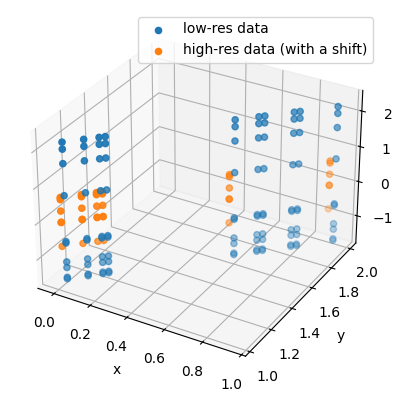

In [221]:
def fun_exp(x,y):
    return 5.*np.sin(x+y) + np.exp(-0.1*x**2 - 0.1*y**2) 

example = '2'
shift0 = 0.05
shift1 = -0.04 


if example ==  '1':
    print('Example 1')
# Example1
    x1 = torch.tensor([0.03, 0.1, 0.15, 0.17, 0.6, 0.68, 0.7, 0.8, 0.82, 0.95]).to(dtype=torch.float64)
    x2 = torch.tensor([0.03, 0.1, 0.14, 0.2, 0.3, 0.97]).to(dtype=torch.float64)
    
    y1 = torch.tensor([1.03, 1.1, 1.15, 1.17, 1.6, 1.68, 1.7, 1.8, 1.82, 1.95]).to(dtype=torch.float64)
    y2 = torch.tensor([1.03, 1.1, 1.14, 1.2, 1.3, 1.97]).to(dtype=torch.float64)
    
    z1 = 0.2*(torch.rand(len(x1),1)-0.5) + (2.*torch.sin(6*x1)).reshape(-1, 1) + 0.5 
    z2 = 0.2*(torch.rand(len(x2),1)-0.5) + torch.sin(6*x2).reshape(-1, 1) 
    
    l1 = 0
    u1 = 1
    
    l2 = 1
    u2 = 2

elif example ==  '2':
    print('Example 2')
# Example2
    x1 = torch.tensor([0.03, 0.1, 0.15, 0.17, 0.6, 0.68, 0.7, 0.8, 0.82, 0.95]).to(dtype=torch.float64)
    x2 = torch.cat( ((x1 - shift0)[:5] , (x1 - shift0)[-1:]), dim=0) 
    
    y1 = torch.tensor([1.03, 1.1, 1.15, 1.17, 1.6, 1.68, 1.7, 1.8, 1.82, 1.95]).to(dtype=torch.float64)
    y2 = torch.cat( ((y1 - shift1)[:5] , (y1 - shift1)[-1:]), dim=0) 
    
    z1 = 0.2*(torch.rand(len(x1),1)-0.5) + (2.*torch.sin(6*x1)).reshape(-1, 1) + 0.5 
    z2 = 0.2*(torch.rand(len(x2),1)-0.5) + torch.sin(6*x2).reshape(-1, 1) 

    l1 = 0
    u1 = 1
    l2 = 1
    u2 = 2
    
elif example ==  '3':
    print('Example 3')
#Example3 
    
    x1 = 3 * torch.rand(20, dtype=torch.float64)  
    y1 = 4 * torch.rand(20, dtype=torch.float64)  
    
    x2 = torch.cat( ((x1 - shift0)[:5] , (x1 - shift0)[-8:-1]), dim=0)
    y2 = torch.cat( ((y1 - shift1)[:5] , (y1 - shift1)[-8:-1]), dim=0)
    
    z1 = 0.2*(torch.rand(len(x1),1)-0.5) + fun_exp(x1,y1).reshape(-1, 1)
    z2 = 0.2*(torch.rand(len(x2),1)-0.5) + fun_exp(x2,y2).reshape(-1, 1)  
    l1 = 0
    u1 = 3
    l2 = 0
    u2 = 4

elif example ==  '4':
    print('Example 4')
#Example4
    x1 = 3 * torch.rand(20, dtype=torch.float64) 
    y1 = 4 * torch.rand(20, dtype=torch.float64)  
    
    x2 = torch.cat( ((x1 - shift0)[:5] , (x1 - shift0)[-8:-1]), dim=0)
    y2 = torch.cat( ((y1 - shift1)[:5] , (y1 - shift1)[-8:-1]), dim=0)
    
    z1 = 0.2*(torch.rand(len(x1),1)-0.5) + (2.*torch.sin(6*x1)).reshape(-1, 1) +0.5*(1) 
    z2 = 0.2*(torch.rand(len(x2),1)-0.5) + torch.sin(6*x2).reshape(-1, 1) 
    l1 = 0
    u1 = 3
    l2 = 0
    u2 = 4


elif example ==  '5':
    print('Example 5')
#Example5
    x1 = torch.linspace(0, 3, 30)
    x2 = torch.cat( ((x1 - shift0)[:5] , (x1 - shift0)[-8:-1]), dim=0)
    
    y1 = torch.linspace(0, 4, 30)
    y2 = torch.cat( ((y1 - shift1)[:5] , (y1 - shift1)[-8:-1]), dim=0)
    
    z1 = fun_exp(x1,y1).reshape(-1, 1) 
    z2 = fun_exp(x2,y2).reshape(-1, 1) 
    
    l1 = 0
    u1 = 3
    l2 = 0
    u2 = 4
######################################################################

X1_stack = torch.stack([x1,y1, torch.zeros_like(x1)],dim=-1)
X2_stack = torch.stack([x2,y2, torch.ones_like(x2)],dim=-1)

X = torch.cat([X1_stack, X2_stack])
y = torch.cat([z1,z2]).reshape(-1, 1)


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x1,y1,z1, label = 'low-res data')
ax.scatter(x2,y2,z2, label = 'high-res data (with a shift)')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.legend()
plt.show()


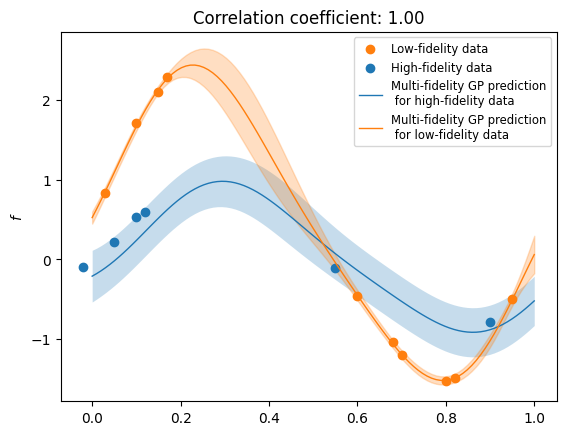

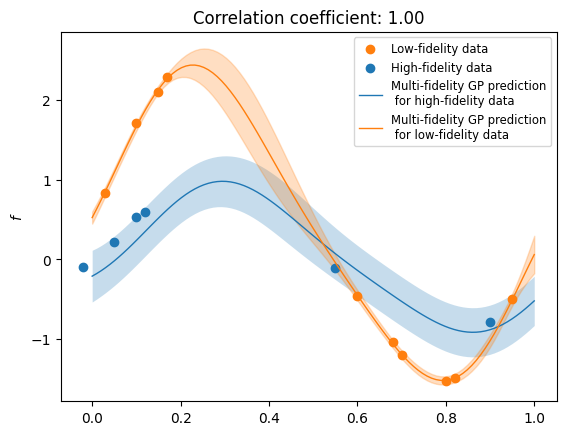

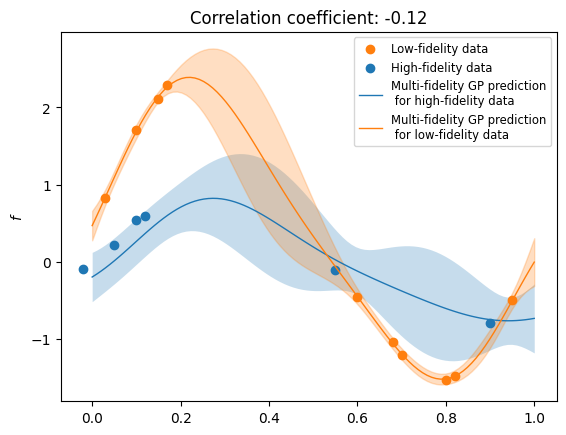

In [222]:
#ShiftedMultiTaskGP
for _ in range(3):
    gp = ShiftedMultiTaskGP(X, y, task_feature=-1, rank=2)
    mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
    fit_gpytorch_mll(mll)
    plot_gp(gp, X, y)